In [1]:
import os
os.environ['HTTP_PROXY'] = "http://127.0.0.1:10809"
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:10809"

In [2]:
import geemap
import ee
Map=geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [3]:
# # 大庆市
# roi = ee.Geometry.Rectangle([123.9355, 45.8362,125.3055, 46.8762])
# # 天津市
# roi = ee.Geometry.Rectangle([115.9244, 38.6272,117.4944,39.6372])
# # 武汉市
# roi = ee.Geometry.Rectangle([113.7393, 29.8642,115.0993, 30.9242])
# # 珠三角
# roi = ee.Geometry.Rectangle([112.7614, 22.2347,114.0514, 23.2547])
# 青藏高原
roi = ee.Geometry.Rectangle([89.8826, 34.6579,91.3626, 35.8279])
Map.addLayer(roi, {}, "roi")
Map.centerObject(roi,9)

In [4]:
## 指数的计算
def water_index(img):
    image = img.clip(roi)
    ndvi=image.normalizedDifference(['B5', 'B4']).rename('NDVI')
    ndwi=image.normalizedDifference(['B3', 'B5']).rename("NDWI")
    mndwi=image.normalizedDifference(['B3', 'B6']).rename("mNDWI")
    ndvi_mndwi = ndvi.subtract(mndwi).rename('ndvi_mndwi')
    cwi=image.select('B3').divide(image.select('B6')).rename("CWI")
    awei = image.expression('B2 + 2.5*B3 - 1.5*(B5+B6) - 0.25*B7',
        {
          'B2': image.select('B2'),
          'B3': image.select('B3'),    
          'B5': image.select('B5'),    
          'B6': image.select('B6'),
          'B7': image.select('B7'),
        }).rename('AWEI')
    ewi = image.expression('(B3 - B5 - B6)/(B3 + B5 + B6)',
        {
          'B3': image.select('B3'),    
          'B5': image.select('B5'),    
          'B6': image.select('B6'),
        }).rename('EWI')
    evi = image.expression('2.5*(B5 - B4)/(B5 + 6*B4 - 7.5*B2 + 1)',
        {
          'B2': image.select('B2'),
          'B4': image.select('B4'),
          'B5': image.select('B5'),    
        }).rename('EVI')
    return image.addBands(ndvi).addBands(ndwi).addBands(mndwi).addBands(cwi).addBands(awei).addBands(ewi).addBands(evi).addBands(ndvi_mndwi)

elevation = ee.Image('USGS/SRTMGL1_003').select('elevation').clip(roi)
def maskSR(img):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = img.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    azimuth = img.get('SOLAR_AZIMUTH_ANGLE')
    zenith = img.get('SOLAR_ZENITH_ANGLE')
    image = img.lt(0)
    bands = image.select('B2').add(image.select('B3')).add(image.select('B4')).add(image.select('B5')).add(image.select('B6')).add(image.select('B7'))
    outlier = bands.gt(0).remap([0,1],[1,0]).rename('outlier')
    return img.updateMask(mask).updateMask(ee.Terrain.hillShadow(elevation,azimuth,zenith,200,True)).updateMask(outlier)

def maskSR_reverse(img):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = img.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    image_cloud = img.updateMask(mask.remap([0,1],[1,0]))
    azimuth = img.get('SOLAR_AZIMUTH_ANGLE')
    zenith = img.get('SOLAR_ZENITH_ANGLE')
    image_shadow = img.updateMask(ee.Terrain.hillShadow(elevation,azimuth,zenith,200,True).remap([0,1],[1,0]))
    image = img.lt(0)
    bands = image.select('B2').add(image.select('B3')).add(image.select('B4')).add(image.select('B5')).add(image.select('B6')).add(image.select('B7'))
    image_outlier = img.updateMask(bands.gt(0).rename('outlier'))
    return ee.ImageCollection([image_cloud,image_shadow,image_outlier]).sum()

# 图像可视化参数
visParams = {'bands': ['B5', 'B6', 'B4'],'min': 0,'max': 3000,'gamma': 1.4}

# 时间序列制图（以像元为单位）

In [5]:
year = 2020
startDate = str(year) + '-01-01'
endDate = str(year) + '-12-31'
l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
       .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi) \
       .filterDate(startDate, endDate) \
       .map(water_index) \
       .map(maskSR)

In [6]:
JRC_id = 'JRC/GSW1_3/YearlyHistory/' + str(year)
Maryland_id = 'users/311605001111/Maryland/Maryland_nationwide_' + str(year)
basemap = ee.Image.constant(0).clip(roi).rename('waterclass')
JRC = ee.Image(JRC_id).clip(roi).remap([0,1,2,3],[0,0,1,2]).rename('waterclass')
JRC_waterclass = ee.ImageCollection([JRC,basemap]).sum()
Maryland = ee.Image(Maryland_id).clip(roi).select('b1').rename('waterclass')
Maryland_permanent = Maryland.select('waterclass').gte(75).remap([0,1],[0,2]).rename('waterclass')
Maryland_season= ee.ImageCollection([Maryland.gte(25),Maryland.lt(75)]).sum().eq(2)
Maryland_waterclass = ee.ImageCollection([Maryland_permanent,Maryland_season,basemap]).sum()
permanentWaterExtent = ee.ImageCollection([JRC_waterclass.eq(2),Maryland_waterclass.eq(2)]).sum().eq(2)
landExtent = ee.ImageCollection([JRC_waterclass.eq(0),Maryland_waterclass.eq(0)]).sum().eq(2)
seasonWaterExtent_max = ee.ImageCollection([permanentWaterExtent,landExtent]).sum().remap([0,1],[1,0]).rename('waterclass')

In [7]:
def max_min(image):
    basemap = ee.Image.constant(0).clip(roi).rename('mNDWI')
    image_basemap = ee.ImageCollection([image.select('mNDWI').updateMask(seasonWaterExtent_max),basemap]).sum()
    return image_basemap

In [9]:
mndwi_max = l8.map(max_min).max()
Map.addLayer(mndwi_max,{'palette':['red','white','blue'],'min':-1,'max':1},'mndwi_max')
mndwi_min = l8.map(max_min).min()
Map.addLayer(mndwi_min,{'palette':['red','white','blue'],'min':-1,'max':1},'mndwi_min')
maxmin = mndwi_max.subtract(mndwi_min)
Map.addLayer(maxmin,{'palette':['red','white','blue'],'min':-2,'max':2},'maxmin')

# maxmin = l8.map(max_min).mean()
# Map.addLayer(maxmin,{'palette':['red','white','blue'],'min':-1,'max':1},'maxmin')

# a = maxmin.reduceRegion(**{
#     'reducer': ee.Reducer.minMax(),
#     'geometry': roi,
#     'scale': 30,
#     'maxPixels': 1e14,
# })
# print(a.getInfo())

Text(0.5, 1.0, 'Region E / 2020')

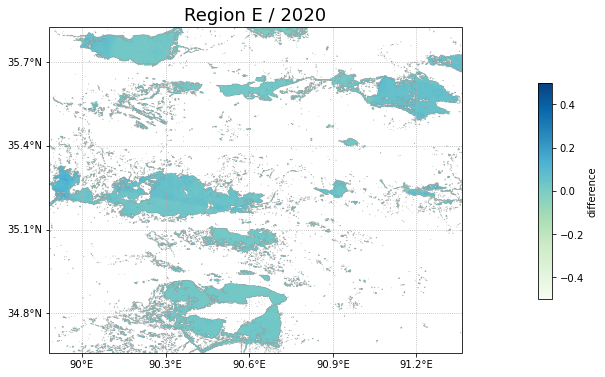

In [13]:
# # 大庆市
# region = [123.9355, 45.8362,125.3055, 46.8762]
# # 天津市
# region = [115.9244, 38.6272,117.4944,39.6372]
# # 武汉市
# region = [113.7393, 29.8642,115.0993, 30.9242]
# # 珠三角
# region = [112.7614, 22.2347,114.0514, 23.2547]
# 青藏高原
region = [89.8826, 34.6579,91.3626, 35.8279]

from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
fig = plt.figure(figsize=(10, 6))
visParams = {'min': -0.5,'max': 0.5}

ax = cartoee.get_map(maxmin.updateMask(seasonWaterExtent_max),region=region,cmap='GnBu',vis_params=visParams)
cartoee.add_colorbar(ax,vis_params=visParams,cmap='GnBu',loc="right",label="difference",orientation="vertical")
cartoee.add_gridlines(ax, interval=[0.3,0.3], linestyle=":")
ax.set_title(label = 'Region E / 2020', fontsize=18)

# 时间序列制图（以景为单位）

## 函数定义

In [ ]:
def time_series(image):
    index = 'mNDWI'
    point = ee.Feature(ee.Geometry.Point([115.75820104148457, 29.251481709867686]))
    second = image.get('system:time_start')
    day = ee.Date(image.get('system:time_start')).format('DD')
    year = ee.Date(image.get('system:time_start')).format('YYYY')
    Min = image.updateMask(seasonWaterExtent_max).select(index).reduceRegion(**{
        'reducer': ee.Reducer.min(),
        'geometry': roi,
        'scale': 30,
        'maxPixels': 1e14,
    })
    Max = image.updateMask(seasonWaterExtent_max).select(index).reduceRegion(**{
        'reducer': ee.Reducer.max(),
        'geometry': roi,
        'scale': 30,
        'maxPixels': 1e14,
    })
    mean = image.updateMask(seasonWaterExtent_max).select(index).reduceRegion(**{
        'reducer': ee.Reducer.mean(),
        'geometry': roi,
        'scale': 30,
        'maxPixels': 1e14,
    })
    return point.setMulti({'day':ee.Number(day),'second':second,'year':year,'max':Max.get(index),'min':Min.get(index),'mean': mean.get(index)})


##  分段处理（按照时间）

In [ ]:
year = 2019
startDate12 = str(year) + '-01-01'
endDate12 = str(year) + '-02-28'
startDate34 = str(year) + '-03-01'
endDate34 = str(year) + '-04-30'
startDate56 = str(year) + '-05-01'
endDate56 = str(year) + '-06-30'
startDate78 = str(year) + '-07-01'
endDate78 = str(year) + '-08-31'
startDate90 = str(year) + '-09-01'
endDate90 = str(year) + '-10-31'
startDate11 = str(year) + '-11-01'
endDate11 = str(year) + '-12-31'


landsat_data = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
        .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
        .filterBounds(roi) \
        .map(water_index) \
        .map(maskSR)
landsat_data12 = landsat_data.filterDate(startDate12, endDate12)
landsat_data34 = landsat_data.filterDate(startDate34, endDate34)
landsat_data56 = landsat_data.filterDate(startDate56, endDate56)
landsat_data78 = landsat_data.filterDate(startDate78, endDate78)
landsat_data90 = landsat_data.filterDate(startDate90, endDate90)
landsat_data11 = landsat_data.filterDate(startDate11, endDate11)

JRC_id = 'JRC/GSW1_3/YearlyHistory/' + str(year)
Maryland_id = 'users/311605001111/Maryland/Maryland_nationwide_' + str(year)
basemap = ee.Image.constant(0).clip(roi).rename('waterclass')
JRC = ee.Image(JRC_id).clip(roi).remap([0,1,2,3],[0,0,1,2]).rename('waterclass')
JRC_waterclass = ee.ImageCollection([JRC,basemap]).sum()
Maryland = ee.Image(Maryland_id).clip(roi).select('b1').rename('waterclass')
Maryland_permanent = Maryland.select('waterclass').gte(75).remap([0,1],[0,2]).rename('waterclass')
Maryland_season= ee.ImageCollection([Maryland.gte(25),Maryland.lt(75)]).sum().eq(2)
Maryland_waterclass = ee.ImageCollection([Maryland_permanent,Maryland_season,basemap]).sum()
permanentWaterExtent = ee.ImageCollection([JRC_waterclass.eq(2),Maryland_waterclass.eq(2)]).sum().eq(2)
landExtent = ee.ImageCollection([JRC_waterclass.eq(0),Maryland_waterclass.eq(0)]).sum().eq(2)
seasonWaterExtent_max = ee.ImageCollection([permanentWaterExtent,landExtent]).sum().remap([0,1],[1,0]).rename('waterclass')

q12 =  landsat_data12.map(time_series).filter(ee.Filter.notNull(['mean'])).sort('second')
q34 =  landsat_data34.map(time_series).filter(ee.Filter.notNull(['mean'])).sort('second')
q56 =  landsat_data56.map(time_series).filter(ee.Filter.notNull(['mean'])).sort('second')
q78 =  landsat_data78.map(time_series).filter(ee.Filter.notNull(['mean'])).sort('second')
q90 =  landsat_data90.map(time_series).filter(ee.Filter.notNull(['mean'])).sort('second')
q11 =  landsat_data11.map(time_series).filter(ee.Filter.notNull(['mean'])).sort('second')

In [ ]:
print(q12.aggregate_array('day').getInfo())
print(q34.aggregate_array('day').getInfo())

In [ ]:
print(q56.aggregate_array('day').getInfo())
print(q78.aggregate_array('day').getInfo())

In [ ]:
print(q90.aggregate_array('day').getInfo())
print(q11.aggregate_array('day').getInfo())

## 制图

In [ ]:
day_str = ee.List(q12.aggregate_array('day')).add(ee.List(q34.aggregate_array('day'))).add(ee.List(q56.aggregate_array('day'))).add(ee.List(q78.aggregate_array('day'))).add(ee.List(q90.aggregate_array('day'))).add(ee.List(q11.aggregate_array('day'))).flatten().getInfo()
day = list(map(int, day_str))
print(day)
mean = ee.List(q12.aggregate_array('mean')).add(ee.List(q34.aggregate_array('mean'))).add(ee.List(q56.aggregate_array('mean'))).add(ee.List(q78.aggregate_array('mean'))).add(ee.List(q90.aggregate_array('mean'))).add(ee.List(q11.aggregate_array('mean'))).flatten().getInfo()
print(mean)
Min = ee.List(q12.aggregate_array('min')).add(ee.List(q34.aggregate_array('min'))).add(ee.List(q56.aggregate_array('min'))).add(ee.List(q78.aggregate_array('min'))).add(ee.List(q90.aggregate_array('min'))).add(ee.List(q11.aggregate_array('min'))).flatten().getInfo()
print(Min)
Max = ee.List(q12.aggregate_array('max')).add(ee.List(q34.aggregate_array('max'))).add(ee.List(q56.aggregate_array('max'))).add(ee.List(q78.aggregate_array('max'))).add(ee.List(q90.aggregate_array('max'))).add(ee.List(q11.aggregate_array('max'))).flatten().getInfo()
print(Max)

%matplotlib inline
# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.figure(figsize=(8,6))
plt.plot(day, mean,'*-b' ,label = 'mean')
plt.plot(day, Min,'^-r' ,label = 'min')
plt.plot(day, Max,'o-g' ,label = 'max')
plt.title("region B/landsat8--mean/min/max ({})".format(year), fontsize=20)
plt.xlabel("day", fontsize=18)
plt.ylabel('mNDWI', fontsize=18)
plt.tick_params(labelsize=15)
plt.show()

## 计算最值

In [ ]:
day_str = ee.List(q12.aggregate_array('day')).add(ee.List(q34.aggregate_array('day'))).add(ee.List(q56.aggregate_array('day'))).add(ee.List(q78.aggregate_array('day'))).add(ee.List(q90.aggregate_array('day'))).add(ee.List(q11.aggregate_array('day'))).flatten().getInfo()
day = list(map(int, day_str))
# print(day)
mean = ee.List(q12.aggregate_array('mean')).add(ee.List(q34.aggregate_array('mean'))).add(ee.List(q56.aggregate_array('mean'))).add(ee.List(q78.aggregate_array('mean'))).add(ee.List(q90.aggregate_array('mean'))).add(ee.List(q11.aggregate_array('mean'))).flatten().getInfo()
# print(mean)
Min = ee.List(q12.aggregate_array('min')).add(ee.List(q34.aggregate_array('min'))).add(ee.List(q56.aggregate_array('min'))).add(ee.List(q78.aggregate_array('min'))).add(ee.List(q90.aggregate_array('min'))).add(ee.List(q11.aggregate_array('min'))).flatten().getInfo()
# print(Min)
Max = ee.List(q12.aggregate_array('max')).add(ee.List(q34.aggregate_array('max'))).add(ee.List(q56.aggregate_array('max'))).add(ee.List(q78.aggregate_array('max'))).add(ee.List(q90.aggregate_array('max'))).add(ee.List(q11.aggregate_array('max'))).flatten().getInfo()
# print(Max)

import numpy as np
print('mean')
print(np.min(mean))
print(np.max(mean))
print(np.mean(mean))

print('max')
print(np.min(Max))
print(np.max(Max))
print(np.mean(Max))

print('min')
print(np.min(Min))
print(np.max(Min))
print(np.mean(Min))


# 线下制图，分解验证

In [ ]:
geemap.ee_to_csv(ee.FeatureCollection(q),'nMDWI_time_series2.csv')

In [ ]:
import pandas as pd

data = pd.read_csv("C:/Users/DELL/Desktop/nMDWI_time_series.csv").dropna(subset=['mean']).sort_values("second")
day = data['day']
mean = data['mean']
min = data['min']
max = data['max']

In [ ]:
%matplotlib inline
# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(8,6))
plt.plot(day, mean,'*-b' ,label = 'mean')
plt.plot(day, min,'^-r' ,label = 'min')
plt.plot(day, max,'o-g' ,label = 'max')
plt.title("region A/landsat8--mean/min/max ({})".format(year), fontsize=20)
plt.xlabel("day", fontsize=18)
plt.ylabel('mNDWI', fontsize=18)

plt.tick_params(labelsize=15)
# plt.xticks([2000,2005,2010,2015,2020])
# plt.legend(prop={'size':15})
plt.show()